In [566]:
import numpy as np
import pandas as pd
import seaborn as sns
import math
import matplotlib.pyplot as plt
from sklearn import preprocessing
from sklearn import pipeline
from sklearn.tree import DecisionTreeRegressor
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split
from sklearn.datasets import load_diabetes

# Generate Dataframe
df = pd.read_csv("uber-fares-dataset/uber.csv")

## Cleaning the Data

Before we start formally cleaning the data, we made sure to take a look at the data we are working with as well as their data types and potential missing values.

Right off the bat, we noted that some latitude and longitude values do not fall within the actual latitude and longitude ranges.
For example, latitude values range between -90 and 90 whereas longitude values range between -180 and 180. Values like -3356.66630 for the longitude will skew the data, so we will need to handle their observational units accordingly.

In [567]:
df.head()

,Unnamed: 0,key,fare_amount,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count
0,24238194,2015-05-07 19:52:06.0000003,7.5,2015-05-07 19:52:06 UTC,-73.999817,40.738354,-73.999512,40.723217,1
1,27835199,2009-07-17 20:04:56.0000002,7.7,2009-07-17 20:04:56 UTC,-73.994355,40.728225,-73.994710,40.750325,1
2,44984355,2009-08-24 21:45:00.00000061,12.9,2009-08-24 21:45:00 UTC,-74.005043,40.740770,-73.962565,40.772647,1
3,25894730,2009-06-26 08:22:21.0000001,5.3,2009-06-26 08:22:21 UTC,-73.976124,40.790844,-73.965316,40.803349,3
4,17610152,2014-08-28 17:47:00.000000188,16.0,2014-08-28 17:47:00 UTC,-73.925023,40.744085,-73.973082,40.761247,5


In [568]:
df.describe()

,Unnamed: 0,fare_amount,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count
count,2.000000e+05,200000.000000,200000.000000,200000.000000,199999.000000,199999.000000,200000.000000
mean,2.771250e+07,11.359955,-72.527638,39.935885,-72.525292,39.923890,1.684535
std,1.601382e+07,9.901776,11.437787,7.720539,13.117408,6.794829,1.385997
min,1.000000e+00,-52.000000,-1340.648410,-74.015515,-3356.666300,-881.985513,0.000000
25%,1.382535e+07,6.000000,-73.992065,40.734796,-73.991407,40.733823,1.000000
50%,2.774550e+07,8.500000,-73.981823,40.752592,-73.980093,40.753042,1.000000
75%,4.155530e+07,12.500000,-73.967154,40.767158,-73.963658,40.768001,2.000000
max,5.542357e+07,499.000000,57.418457,1644.421482,1153.572603,872.697628,208.000000


From the .info() function we found that the longitude and latitude values contain a null value. We will need to address that later during our data cleanup.

In [569]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200000 entries, 0 to 199999
Data columns (total 9 columns):
 #   Column             Non-Null Count   Dtype  
---  ------             --------------   -----  
 0   Unnamed: 0         200000 non-null  int64  
 1   key                200000 non-null  object 
 2   fare_amount        200000 non-null  float64
 3   pickup_datetime    200000 non-null  object 
 4   pickup_longitude   200000 non-null  float64
 5   pickup_latitude    200000 non-null  float64
 6   dropoff_longitude  199999 non-null  float64
 7   dropoff_latitude   199999 non-null  float64
 8   passenger_count    200000 non-null  int64  
dtypes: float64(5), int64(2), object(2)
memory usage: 13.7+ MB


We decided to plot fare_amount vs passenger count to see if we could find any correlations for data evaluation, and we found that the passenger count contains an outlier, which we will also need to address during the data cleanup.

<AxesSubplot:xlabel='fare_amount', ylabel='passenger_count'>

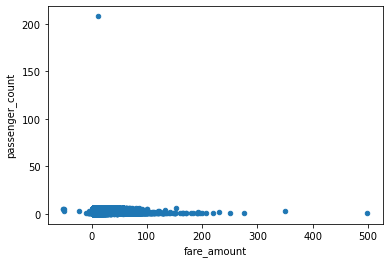

In [570]:
df.plot(kind="scatter", x="fare_amount", y="passenger_count")

To combat the rather strange values in the latitude and longitude columns, we will need to remove any observational units that do not fall within the specified latitude and longitude range. 

Before doing so, we will first need to drop any null values from our dataset.

In [571]:
df = df.dropna()

In [572]:
# Drop Pickup Latitude & Longitude Values Outside of Range
df.drop(df.loc[df['pickup_latitude'] > 90].index, inplace=True)
df.drop(df.loc[df['pickup_latitude'] < -90].index, inplace=True)

df.drop(df.loc[df['pickup_longitude'] > 180].index, inplace=True)
df.drop(df.loc[df['pickup_longitude'] < -180].index, inplace=True)


/Users/sofiamurillosanchez/opt/anaconda3/lib/python3.9/site-packages/pandas/core/frame.py:4906: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().drop(


In [573]:
# Drop Dropoff Latitude & Longitude Values Outside of Range
df.drop(df.loc[df['dropoff_latitude'] > 90].index, inplace=True)
df.drop(df.loc[df['dropoff_latitude'] < -90].index, inplace=True)

df.drop(df.loc[df['dropoff_longitude'] > 180].index, inplace=True)
df.drop(df.loc[df['dropoff_longitude'] < -180].index, inplace=True)


In [574]:
# Drop the outlier in the passenger_count
df.drop(df.loc[df['passenger_count'] > 200].index, inplace=True)
df.drop(df.loc[df['passenger_count'] <= 0].index, inplace=True)

Because a lot of Uber fares are related to the distance traveled and demand (but demand cannot be calculated in this context), we will calculate the distance traveled for each Uber ride and create a variable containing the distance traveled. Hopefully, from this calculation we can see an accurate reflection of the correlation between the variables.

In [575]:
# Convert the latitude and longitude values to radians for calculation purposes
np.radians(df['pickup_latitude'])
np.radians(df['pickup_longitude'])

np.radians(df['dropoff_latitude'])
np.radians(df['dropoff_longitude'])

0        -1.291535
1        -1.291451
2        -1.290890
3        -1.290938
4        -1.291074
            ...   
199995   -1.291308
199996   -1.291660
199997   -1.289082
199998   -1.291251
199999   -1.291291
Name: dropoff_longitude, Length: 199278, dtype: float64

In [576]:
# Calculation Reference: https://www.geeksforgeeks.org/program-distance-two-points-earth/#:~:text=For%20this%20divide%20the%20values,is%20the%20radius%20of%20Earth. 
# Distance, d = 3963.0 * arccos[(sin(lat1) * sin(lat2)) + cos(lat1) * cos(lat2) * cos(long2 – long1)]

df['distance_traveled'] = 3963.0 * np.arccos(((np.sin(df['pickup_latitude']) * np.sin(df['dropoff_latitude'])) + np.cos(df['pickup_latitude']) * np.cos(df['dropoff_latitude']) * np.cos(df['dropoff_longitude']-df['pickup_longitude'])))

/Users/sofiamurillosanchez/opt/anaconda3/lib/python3.9/site-packages/pandas/core/arraylike.py:364: RuntimeWarning: invalid value encountered in arccos
  result = getattr(ufunc, method)(*inputs, **kwargs)
/var/folders/2l/1pcx9h911c70k9vsjfgymhyh0000gn/T/ipykernel_45569/479766030.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['distance_traveled'] = 3963.0 * np.arccos(((np.sin(df['pickup_latitude']) * np.sin(df['dropoff_latitude'])) + np.cos(df['pickup_latitude']) * np.cos(df['dropoff_latitude']) * np.cos(df['dropoff_longitude']-df['pickup_longitude'])))


In [577]:
# Converting the date & time variable to an actual date & time Dtype
df.pickup_datetime = pd.to_datetime(df.pickup_datetime)

/Users/sofiamurillosanchez/opt/anaconda3/lib/python3.9/site-packages/pandas/core/generic.py:5516: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[name] = value


In [578]:
# Creating day and hour variables using pickup_datetime, will use to calculate effect of timing/date on fare

df['day'] = df.pickup_datetime.dt.weekday
df['hour'] = df.pickup_datetime.dt.hour

/var/folders/2l/1pcx9h911c70k9vsjfgymhyh0000gn/T/ipykernel_45569/3758761965.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['day'] = df.pickup_datetime.dt.weekday
/var/folders/2l/1pcx9h911c70k9vsjfgymhyh0000gn/T/ipykernel_45569/3758761965.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['hour'] = df.pickup_datetime.dt.hour


In [579]:
# Drop any values = to infinity

df.replace([np.inf, -np.inf], np.nan, inplace=True)
df.dropna(inplace=True)

/Users/sofiamurillosanchez/opt/anaconda3/lib/python3.9/site-packages/pandas/core/frame.py:5238: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().replace(
/Users/sofiamurillosanchez/opt/anaconda3/lib/python3.9/site-packages/pandas/util/_decorators.py:311: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return func(*args, **kwargs)


From taking a look at .info() and .describe, we can see that there are no longer any null/inf values and all the latitude and longitude values fall within normal ranges. Now we can start with our preprocessing.

In [580]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 199165 entries, 0 to 199999
Data columns (total 12 columns):
 #   Column             Non-Null Count   Dtype              
---  ------             --------------   -----              
 0   Unnamed: 0         199165 non-null  int64              
 1   key                199165 non-null  object             
 2   fare_amount        199165 non-null  float64            
 3   pickup_datetime    199165 non-null  datetime64[ns, UTC]
 4   pickup_longitude   199165 non-null  float64            
 5   pickup_latitude    199165 non-null  float64            
 6   dropoff_longitude  199165 non-null  float64            
 7   dropoff_latitude   199165 non-null  float64            
 8   passenger_count    199165 non-null  int64              
 9   distance_traveled  199165 non-null  float64            
 10  day                199165 non-null  int64              
 11  hour               199165 non-null  int64              
dtypes: datetime64[ns, UTC](1), flo

In [581]:
df.describe()

,Unnamed: 0,fare_amount,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,distance_traveled,day,hour
count,1.991650e+05,199165.000000,199165.000000,199165.000000,199165.000000,199165.000000,199165.000000,199165.000000,199165.000000,199165.000000
mean,2.771724e+07,11.367451,-72.503134,39.918590,-72.512632,39.922496,1.689489,147.604705,3.049381,13.492742
std,1.601431e+07,9.909977,10.445844,6.129783,10.409178,6.117640,1.305390,360.789741,1.946611,6.516453
min,1.000000e+00,-52.000000,-93.824668,-74.015515,-75.458979,-74.015750,1.000000,0.000000,0.000000,0.000000
25%,1.382813e+07,6.000000,-73.992062,40.734798,-73.991407,40.733829,1.000000,49.210683,1.000000,9.000000
50%,2.775737e+07,8.500000,-73.981826,40.752585,-73.980095,40.753042,1.000000,85.046336,3.000000,14.000000
75%,4.156231e+07,12.500000,-73.967170,40.767155,-73.963670,40.767995,2.000000,151.705649,5.000000,19.000000
max,5.542357e+07,499.000000,40.808425,48.018760,40.831932,45.031598,6.000000,12056.697494,6.000000,23.000000


## Using OneHotEncoder & Scaling, Normalizing, and Standardizing Features using sklearn.preprocessing

Before we jump into anything else, we decided on preprocessing the data in order to standardize the dataset. This will make the rest of the process run smoother because the data will "change raw feature vectors into a representation that is more suitable for the downstream estimators." (Source: https://scikit-learn.org/stable/modules/preprocessing.html)

In [ ]:
# Drop the key, unname, pickup_datetime, long & lat variables (extracted the necessary information from these variables/their variable types interfere with the scaler)
df_scale = df.drop({"key", 'pickup_datetime', 'Unnamed: 0', 'pickup_longitude', 'pickup_latitude', 'dropoff_longitude', 'dropoff_latitude'}, axis = 1)
df_scale.drop_duplicates(inplace=True)
df_scale.info()

Before running the scaler on the data, we will need to drop any categorical variables/any variables that are not in a number format because the scaler only works with number data.

Then, we will run the StandardScaler on the dataframe and check the mean and scale.

In [601]:
scaler = preprocessing.StandardScaler().fit(df_scale)

In [602]:
scaler.mean_

array([ 11.36745136,   1.68948861, 147.60470477,   3.04938117,
        13.4927422 ])

In [603]:
scaler.scale_

array([  9.90995236,   1.30538675, 360.78883569,   1.94660651,
         6.5164362 ])

Next, we will transform the scaler and store it in a new dataframe and also check the mean and standard deviation.

In [604]:
df_scaled = scaler.transform(df_scale)
df_scaled.mean(axis=0)

array([-1.01177375e-16, -9.95362756e-18, -8.54085462e-17, -4.95897574e-17,
        1.23796013e-17])

In [605]:
df_scaled.std(axis=0)

array([1., 1., 1., 1., 1.])

After scaling the data, we created a correlation matrix to see how the rest of the data relates to the fare amount. From looking at the correlation matrix, we found that none of the columns have a strong correlation to the fare amount.

In [606]:
corr_matrix = df_scale.corr()

In [607]:
corr_matrix["fare_amount"].sort_values(ascending=False)

fare_amount          1.000000
distance_traveled    0.367627
passenger_count      0.009927
day                  0.007466
hour                -0.021585
Name: fare_amount, dtype: float64

## Use sklearn.tree.DecisionTreeRegressor & Use k-fold Cross Validation (cross_val_score)

In [590]:
X = df_scale['distance_traveled']
y = df_scale['fare_amount']
X, y = load_diabetes(return_X_y=True)
regressor = DecisionTreeRegressor(random_state=0)
regressor.fit(X,y)

# Cross Validation Score
cross_val_score(regressor, X, y, cv=10)

array([-0.39292219, -0.46749346,  0.02768473,  0.06441362, -0.50323135,
        0.16437202,  0.11242982, -0.73798979, -0.30953155, -0.00137327])

In [591]:
X_test = np.arange(0, 500, 10)[:, np.newaxis]
y_1 = regressor.predict(X_test)

ValueError: X has 1 features, but DecisionTreeRegressor is expecting 10 features as input.

ValueError: x and y must be the same size

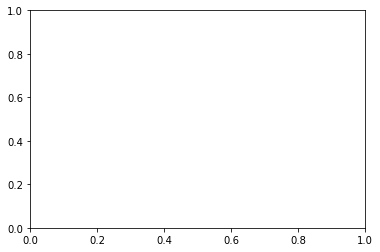

In [ ]:
#y_pred = regressor.predict(X)
plt.figure()
plt.scatter(X, y, s=20, edgecolor="black", c="darkorange", label="data")

In [ ]:
# Referenced from O'Reilley Hands On Machine Learning Textbook

def split_train_test(data, test_ratio):
    shuffled_indices = np.random.permutation(len(data))
    test_set_size = int(len(data) * test_ratio)
    test_indices = shuffled_indices[:test_set_size]
    train_indices = shuffled_indices[test_set_size:]
    return data.iloc[train_indices], data.iloc[test_indices]

In [ ]:
train_set, test_set = split_train_test(df, 0.2)
train_set.info()

AttributeError: 'numpy.ndarray' object has no attribute 'iloc'

In [ ]:
from zlib import crc32

def test_set_check(identifier, test_ratio):
    return crc32(np.int64(identifier)) & 0xffffffff < test_ratio * 2**32


In [ ]:
pipe = make_pipeline(StandardScaler(), DecisionTreeRegressor())
pipe.fit(X, y)
pipe.score(X, y)

1.0